## Training the Emotion Detection Model:

### In this section we will be training the emotion detection model and we will try to achieve a good accuracy for          the model.

In [1]:
"""
    Import all the important required Deep Learning Libraries to train the emotions model.
    
    Keras is an Application Programming Interface (API) which can run on top of tensorflow.
    
    tensorflow will be the main deep learning module we will use to build our deep learning model.
    
    The ImageDataGenerator is used for Data augmentation where the model can see more copies of 
        the model. Data Augmentation is used for creating replications of the original images 
        and using those transformations in each epoch.
        
    The layers for training which will be used are as follows:
    1. Input = The input layer which we pass the input shape.
    2. Conv2D = The Convoluional layer combined with Input to provide a output of tensors
    3. Maxpool2D = Downsampling the Data from the convolutional layer.
    4. Batch normalization = It is a technique for training very deep neural networks that standardizes 
       the inputs to a layer for each mini-batch. This has the effect of stabilizing the learning 
       process and dramatically reducing the number of training epochs required to train deep networks.
    5. Dropout = Dropout is a technique where randomly selected neurons are ignored during training. 
                 They are “dropped-out” randomly and this prevents over-fitting.
    6. Dense = Fully Connected layers.
    7. Flatten = Flatten the entire structure to a 1-D array.
    
    The Models can be built in a model like structure or can be built in a sequential manner.
        
    Use of l2 regularization for fine tuning.
    
    The optimizer used will be Adam as it is performs better than the other optimizers on this model.
    
    Numpy for numerical array like operations.
    
    pydot_ng and graphviz are used for making plots.
    
    We are also importing the os module to make it compatible with the windows environment. 
    
"""

import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Dense, Flatten, Activation
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import numpy as np
import pydot_ng
import graphviz
import os

Using TensorFlow backend.


In [2]:
"""
    num_classes = Defines the number of classes we have to predict which are namely 
    Angry, Fear, Happy, Neutral, Surprise and Neutral.
    
    From the exploratory Data Analysis we know that The Dimensions of the image are:
    Image Height = 48 pixels
    Image Width = 48 pixels
    Number of classes = 1 because it is a grayscale image.
    
    We will consider a batch size for the training of the image augmentation.

"""

num_classes = 6

Img_Height = 48
Img_width = 48

batch_size = 32

In [3]:
"""
    Specify the train and the validation directory for the stored images.
    train_dir is the directory which will contain the set of images for training.
    validation_dir is the directory will contain the set of validation images.

"""

train_dir = "train"
validation_dir = "validation"

### Data Augmentation of images:

In [4]:
"""
    Reference: https://keras.io/api/preprocessing/image/
    
    The ImageDataGenerator is used for data augmentation of images. 
    We will be replicating and making copies of the transformations of the
    original images. The Keras Data Generator will use the copies and
    not the original ones. This will be useful for training at each epoch.
    
    We will be recaling the image and updating all the parameters to suit our model
    1. rescale = Rescaling by 1./255 to normalize each of the pixel values
    2. rotation_range = specifies the random range of rotation
    3. shear_range = Specifies the intensity of each angle in counter-clockwise range.
    4. zoom_range = Specifies the zoom range. 
    5. width_shift_range = specify the width of the extension.
    6. height_shift_range = Specify the height of the extension.
    7. horizontal_flip = Flip the images horizontally.
    8. fill_mode = Fill according to the closest boundaries.
    
    train_datagen.flow_from_directory Takes the path to a directory & generates batches of 
    augmented data. The properties callable are as follows:
    
    1. train dir = Specifies the directory where we have stored the image data.
    2. color_mode = Important feature which we need to specify how our images are
        categorized i.e. grayscale or RGB format. Default is RGB.
    3. target_size = The Dimensions of the image.
    4. batch_size = The number of batches of data for the flow operation.
    5. class_mode = Determines the type of label arrays that are returned.
        "categorical" will be 2D one-hot encoded labels.
    6. shuffle = shuffle: Whether to shuffle the data (default: True) 
        If set to False, sorts the data in alphanumeric order.

"""

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=60,
                                   shear_range=0.5,
                                   zoom_range=0.5,
                                   width_shift_range=0.5,
                                   height_shift_range=0.5,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    color_mode='grayscale',
                                                    target_size=(Img_Height, Img_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                              color_mode='grayscale',
                                                              target_size=(Img_Height, Img_width),
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              shuffle=True)

Found 28353 images belonging to 6 classes.
Found 3534 images belonging to 6 classes.


### Emotions Model:

In [5]:
"""
    We will be using a sequential type architecture for our model.
    Our Sequential model will have a total of 5 blocks i.e. three
    convolutional blocks, one fully connected layer and one output
    layer.
    
    We will have 3 Convolutional Blocks with filters of increasing size
    as 32, 64 and 128 respectively. The kernel_size will be (3,3) and
    the kernel_initializer will be he_normal. We can also use a 
    kernel_regularizer with l2 normalization. Our Preferred choice of 
    activation is elu because it usually performs better on images.
    The Input shape will be the same as the size of each of our train and
    validation images.
    The BatchNormalization layer Batch normalization is a technique for improving 
    the speed, performance, and stability of artificial neural networks.
    and Maxpooling is used to Downsample the data. 
    The Dropout layer is used for prevention of overfitting.
    
    The fully connected block consists of a Dense layer of 64 filters
    and a batch normalization followed by a dropout layer. Before passing
    through the Dense layer the data is flattened to match the dimensions.
    
    Finally the output layer consists of a Dense layer with a softmax
    activation to give probabilites according to the num_classes which
    represents the number of predictions to be made. 

"""

model = Sequential()

# Block-1: The First Convolutional Block

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', 
                 kernel_initializer='he_normal',
                 activation="elu", 
                 input_shape=(Img_Height, Img_width, 1), 
                 name="Conv1"))

model.add(BatchNormalization(name="Batch_Norm1"))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', 
                 kernel_initializer='he_normal', 
                 activation="elu", name="Conv2"))

model.add(BatchNormalization(name="Batch_Norm2"))
model.add(MaxPooling2D(pool_size=(2,2), name="Maxpool1"))
model.add(Dropout(0.2, name="Dropout1"))

# Block-2: The Second Convolutional Block

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', 
                 kernel_initializer='he_normal',
                 activation="elu", name="Conv3"))

model.add(BatchNormalization(name="Batch_Norm3"))

model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',
                 kernel_initializer='he_normal', 
                 activation="elu", name="Conv4"))

model.add(BatchNormalization(name="Batch_Norm4"))
model.add(MaxPooling2D(pool_size=(2,2), name="Maxpool2"))
model.add(Dropout(0.2, name="Dropout2"))

# Block-3: The Third Convolutional Block

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', 
                 kernel_initializer='he_normal', 
                 activation="elu", name="Conv5"))

model.add(BatchNormalization(name="Batch_Norm5"))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', 
                 kernel_initializer='he_normal',
                 activation="elu", name="Conv6"))

model.add(BatchNormalization(name="Batch_Norm6"))
model.add(MaxPooling2D(pool_size=(2,2), name="Maxpool3"))
model.add(Dropout(0.2, name="Dropout3"))

# Block-4: The Fully Connected Block

model.add(Flatten(name="Flatten"))
model.add(Dense(64, activation="elu", kernel_initializer='he_normal', name="Dense"))
model.add(BatchNormalization(name="Batch_Norm7"))
model.add(Dropout(0.5, name="Dropout4"))

# Block-5: The Output Block

model.add(Dense(num_classes, activation="softmax", kernel_initializer='he_normal', name = "Output"))

### Model Summary: 

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 48, 48, 32)        320       
_________________________________________________________________
Batch_Norm1 (BatchNormalizat (None, 48, 48, 32)        128       
_________________________________________________________________
Conv2 (Conv2D)               (None, 48, 48, 32)        9248      
_________________________________________________________________
Batch_Norm2 (BatchNormalizat (None, 48, 48, 32)        128       
_________________________________________________________________
Maxpool1 (MaxPooling2D)      (None, 24, 24, 32)        0         
_________________________________________________________________
Dropout1 (Dropout)           (None, 24, 24, 32)        0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 24, 24, 64)        1

### Model Plot:

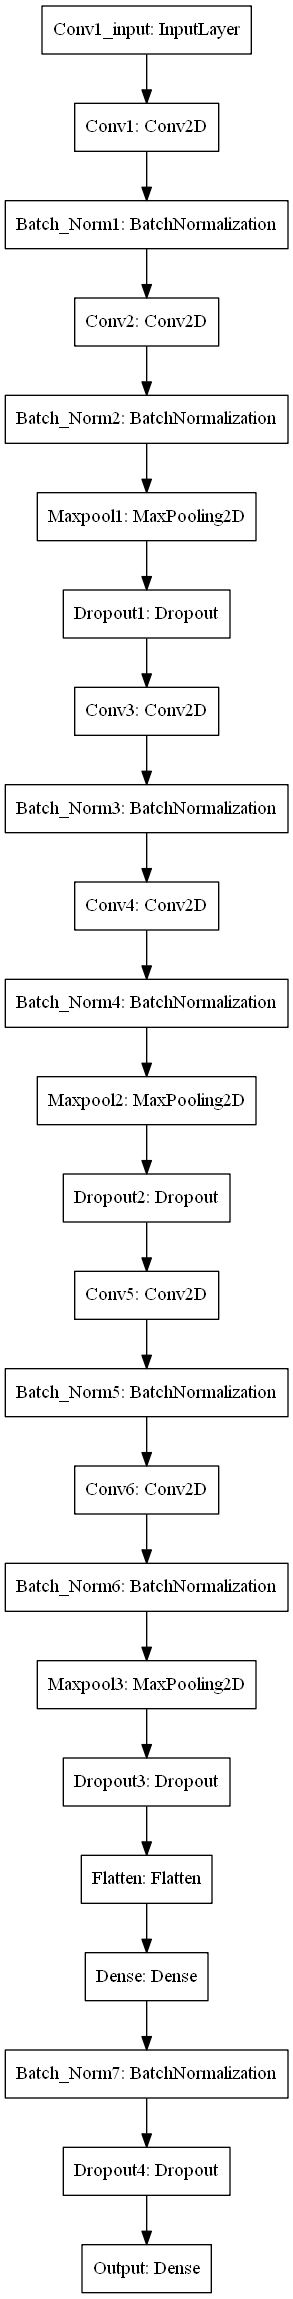

In [7]:
from tensorflow import keras
from keras.utils.vis_utils import plot_model
from keras.utils import np_utils

keras.utils.plot_model(model, to_file='model.png', show_layer_names=True)

### Callbacks:

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard

checkpoint = ModelCheckpoint("emotions.h5", monitor='accuracy', verbose=1,
                              save_best_only=True, mode='auto', period=1)

reduce = ReduceLROnPlateau(monitor='accuracy', factor=0.2, patience=10, 
                           min_lr=0.0001, verbose = 1)

logdir='logs'
tensorboard_Visualization = TensorBoard(log_dir=logdir, histogram_freq=False)

### Compile the Model:

In [9]:
model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr = 0.001),
              metrics=['accuracy'])

### Fit the Model:

In [10]:
train_samples = 28353
validation_samples = 3534
epochs = 150
batch_size = 64

model.fit(train_generator,
          steps_per_epoch = train_samples//batch_size,
          epochs = epochs,
          callbacks = [checkpoint, reduce, tensorboard_Visualization],
          validation_data = validation_generator,
          validation_steps = validation_samples//batch_size,
          shuffle=True)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 443 steps, validate for 55 steps
Epoch 1/150
441/443 [============================>.] - ETA: 0s - loss: 2.1374 - accuracy: 0.1932
Epoch 00001: accuracy improved from -inf to 0.19300, saving model to emotions.h5
443/443 [==============================] - 24s 53ms/step - loss: 2.1371 - accuracy: 0.1930 - val_loss: 1.9720 - val_accuracy: 0.2330
Epoch 2/150
442/443 [============================>.] - ETA: 0s - loss: 1.8418 - accuracy: 0.2162
Epoch 00002: accuracy improved from 0.19300 to 0.21612, saving model to emotions.h5
443/443 [==============================] - 17s 38ms/step - loss: 1.8417 - accuracy: 0.2161 - val_loss: 1.7508 - val_accuracy: 0.2483
Epoch 3/150
440/443 [============================>.] - ETA: 0s - loss: 1.7700 - accuracy: 0.2398
Epoch 00003: accuracy improved from 0.21612 to 0.23956, saving model to emotions.h5
443/443 [==============================] - 11s 25ms/step - loss: 1.7701 - accuracy: 0.2396 - val_loss

440/443 [============================>.] - ETA: 0s - loss: 1.4176 - accuracy: 0.4383
Epoch 00054: accuracy did not improve from 0.44093
443/443 [==============================] - 9s 20ms/step - loss: 1.4169 - accuracy: 0.4389 - val_loss: 1.4709 - val_accuracy: 0.4727
Epoch 55/150
440/443 [============================>.] - ETA: 0s - loss: 1.4165 - accuracy: 0.4377
Epoch 00055: accuracy did not improve from 0.44093
443/443 [==============================] - 9s 20ms/step - loss: 1.4164 - accuracy: 0.4377 - val_loss: 1.4511 - val_accuracy: 0.4824
Epoch 56/150
442/443 [============================>.] - ETA: 0s - loss: 1.4166 - accuracy: 0.4349
Epoch 00056: accuracy did not improve from 0.44093
443/443 [==============================] - 9s 20ms/step - loss: 1.4162 - accuracy: 0.4350 - val_loss: 1.5137 - val_accuracy: 0.4886
Epoch 57/150
442/443 [============================>.] - ETA: 0s - loss: 1.4051 - accuracy: 0.4436
Epoch 00057: accuracy improved from 0.44093 to 0.44371, saving model to 

Epoch 83/150
441/443 [============================>.] - ETA: 0s - loss: 1.3681 - accuracy: 0.4648
Epoch 00083: accuracy improved from 0.46356 to 0.46483, saving model to emotions.h5
443/443 [==============================] - 9s 20ms/step - loss: 1.3677 - accuracy: 0.4648 - val_loss: 1.4586 - val_accuracy: 0.5080
Epoch 84/150
442/443 [============================>.] - ETA: 0s - loss: 1.3726 - accuracy: 0.4598
Epoch 00084: accuracy did not improve from 0.46483
443/443 [==============================] - 10s 22ms/step - loss: 1.3722 - accuracy: 0.4599 - val_loss: 1.4418 - val_accuracy: 0.4977
Epoch 85/150
442/443 [============================>.] - ETA: 0s - loss: 1.3636 - accuracy: 0.4628
Epoch 00085: accuracy did not improve from 0.46483
443/443 [==============================] - 9s 20ms/step - loss: 1.3639 - accuracy: 0.4627 - val_loss: 1.4168 - val_accuracy: 0.4989
Epoch 86/150
442/443 [============================>.] - ETA: 0s - loss: 1.3652 - accuracy: 0.4632
Epoch 00086: accuracy did

Epoch 111/150
440/443 [============================>.] - ETA: 0s - loss: 1.3168 - accuracy: 0.4840
Epoch 00111: accuracy did not improve from 0.48887
443/443 [==============================] - 9s 20ms/step - loss: 1.3168 - accuracy: 0.4839 - val_loss: 1.4279 - val_accuracy: 0.5210
Epoch 112/150
442/443 [============================>.] - ETA: 0s - loss: 1.3145 - accuracy: 0.4851
Epoch 00112: accuracy did not improve from 0.48887
443/443 [==============================] - 9s 20ms/step - loss: 1.3147 - accuracy: 0.4850 - val_loss: 1.4419 - val_accuracy: 0.5182
Epoch 113/150
440/443 [============================>.] - ETA: 0s - loss: 1.3180 - accuracy: 0.4840
Epoch 00113: accuracy did not improve from 0.48887
443/443 [==============================] - 9s 20ms/step - loss: 1.3183 - accuracy: 0.4837 - val_loss: 1.4226 - val_accuracy: 0.5222
Epoch 114/150
442/443 [============================>.] - ETA: 0s - loss: 1.3089 - accuracy: 0.4854
Epoch 00114: accuracy did not improve from 0.48887
443/

### Graph:

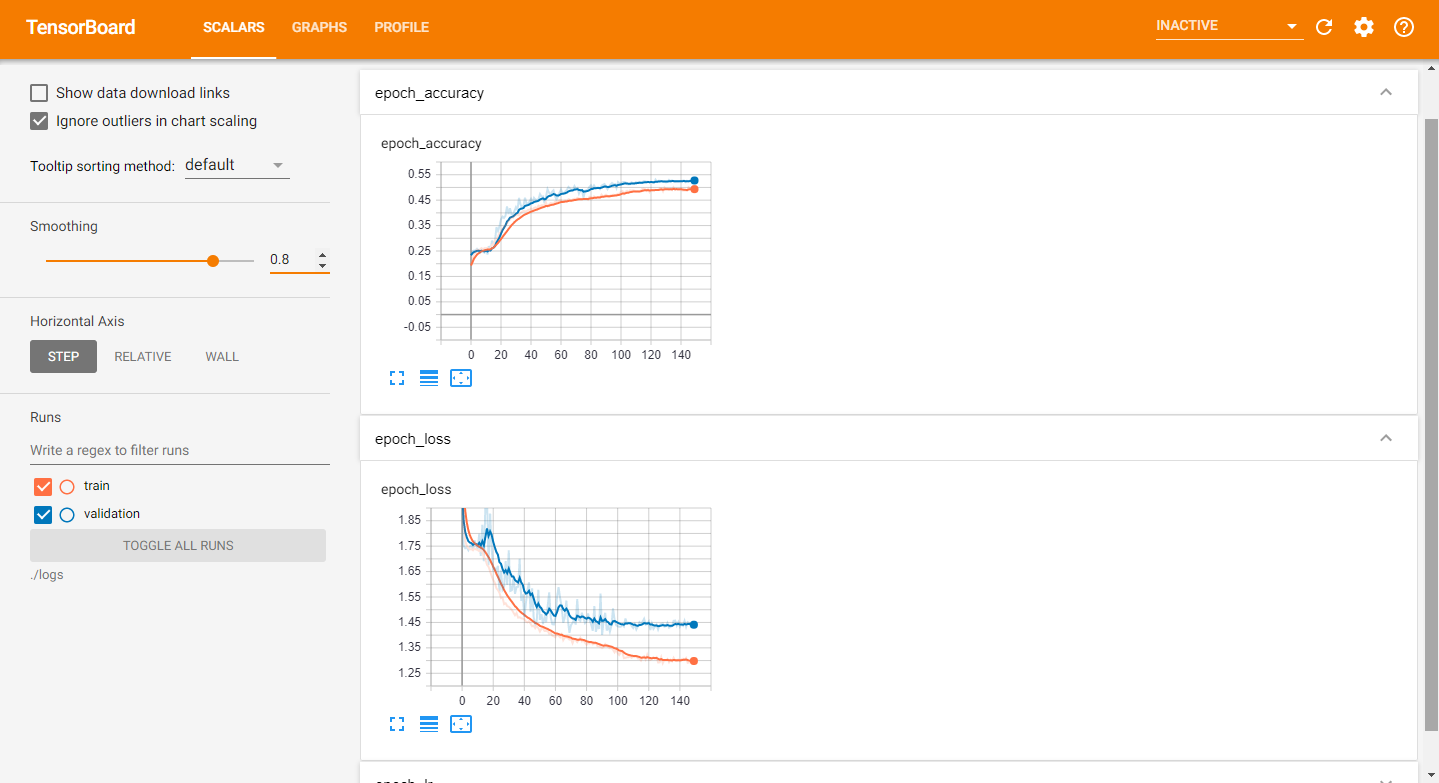

In [11]:
"""
    To access the logs and graphs type the below command in the
    command prompt :
    tensorboard --logdir="./logs"
    
    Copy the URL link given and go the location to see the graphs
    via the local system.
    
    Below is a screenshot of the the graphs from Tensorboard.
    
"""

from IPython.display import Image 

pil_img = Image(filename='emotions_graph1.png')
display(pil_img)

### The Model is able to perform quite well. We can notice that the train and validation losses are decreasing constantly and the train as well as validation accuracy increases constantly. There is no overfitting in the deep learning model and we are able to achieve an validation accuracy of over 53%.